In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbayesassay as cba
import attila_utils

In [2]:
fpathl = [
    '../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv',
    #'../../results/2024-02-14-cell-bayes/H102_posteriors.csv',
    #'../../results/2024-01-21-cell-bayes-assays-dim/H102_posteriors.csv'
]
l = [pd.read_csv(fpath, index_col=[0, 1], header=[0, 1]) for fpath in fpathl]
H102_posteriors1 = pd.concat([l[0]], axis=1)
#H102_posteriors1 = pd.concat([l[0], l[1].drop('Arundine', level=0, axis=1)], axis=1)
H102_posteriors1 = H102_posteriors1.stack(level=0)
H102_posteriors1['name'] = H102_posteriors1.index.get_level_values(2)
name2TI = {
    'TUDCA': ('CO25360', 'TI21'),
    'Cysteamine': ('CO25360', 'TI22'),
    'Arundine': ('CO25360', 'TI26'),
    'C-DIM5': ('CO28151', 'TI11'),
    'C-DIM12': ('CO28151', 'TI12'),
}
l = [H102_posteriors1.name.apply(lambda x: name2TI[x][i]).to_frame(c) for i, c in zip(range(2), ['study', 'TI'])]
ixdf = pd.concat([l[0], H102_posteriors1.index.to_frame().iloc[:, :-1].rename({0: 'experiment', 1:'assay'}, axis=1), l[1]], axis=1)
H102_posteriors1 = pd.DataFrame(H102_posteriors1.to_numpy(), index=pd.MultiIndex.from_frame(ixdf), columns=H102_posteriors1.columns.to_list())
H102_posteriors1

H1  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.879   
                                                            TI22      0.0   
                                                            TI21  0.99275   
                                                    Aβ42 SN TI26    0.373   
                                                            TI22    0.002   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI21  0.00025   
                                                    YOPRO   TI26   0.0005   
                                                            TI22      0.0   
                                                            TI21  0.00875   

                                                                       H0  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26     0.12   
                                                            TI22      0.0   
                                                            TI21  0.00725   
                                                    Aβ42 SN TI26   0.6255   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI21  0.93475   
                                                    YOPRO   TI26    0.977   
                                                            TI22  0.95175   
                                                            TI21  0.97275   

                                                                       H2  \
study   experiment                                  assay   TI              
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    0.001   
                                                            TI22      1.0   
                                                            TI21      0.0   
                                                    Aβ42 SN TI26   0.0015   
                                                            TI22  0.81625   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22   0.0165   
                                                            TI21    0.065   
                                                    YOPRO   TI26   0.0225   
                                                            TI22  0.04825   
                                                            TI21   0.0185   

                                                                        name  
study   experiment                                  assay   TI                
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    Aβ42 SN TI26    Arundine  
                                                            TI22  Cysteamine  
...                                                                      ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  Cysteamine  
                                                            TI21       TUDCA  
                                                    YOPRO   TI26    Arundine  
                                                            TI22  Cysteamine  
                                                            TI21       TUDCA  

[91 rows x 4 columns]

In [3]:
H102_posteriors2 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=list(range(4)))
H102_posteriors = pd.concat([H102_posteriors1, H102_posteriors2], axis=0)
H102_posteriors

H1       H0       H2  \
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26    0.879     0.12    0.001   
                                         TI22      0.0      0.0      1.0   
                                         TI21  0.99275  0.00725      0.0   
                                 Aβ42 SN TI26    0.373   0.6255   0.0015   
                                         TI22    0.002  0.18175  0.81625   
...                                                ...      ...      ...   
CO28151 Aβ release (H4 cells)    Aβ42    TI11      0.0  0.37325  0.62675   
                                         TI12      0.0    0.002    0.998   
                                         TI13   0.0265  0.95625  0.01725   
                                         TI14  0.00025    0.953  0.04675   
                                         TI15  0.06325  0.93675      0.0   

                                                                     name  
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26                    Arundine  
                                         TI22                  Cysteamine  
                                         TI21                       TUDCA  
                                 Aβ42 SN TI26                    Arundine  
                                         TI22                  Cysteamine  
...                                                                   ...  
CO28151 Aβ release (H4 cells)    Aβ42    TI11               DIM-C-pPhOCH3  
                                         TI12                     C-DIM12  
                                         TI13                 Liraglutide  
                                         TI14                 Semaglutide  
                                         TI15  Hydroxychloroquine racemic  

[166 rows x 4 columns]

In [4]:
BF10 = cba.BF10_from_H102_posteriors_long(cba.pseudocount_to_H102_posteriors(H102_posteriors))
BF10

Study  \
study   experiment               assay   TI              
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26  CO25360   
                                         TI22  CO25360   
                                         TI21  CO25360   
                                 Aβ42 SN TI26  CO25360   
                                         TI22  CO25360   
...                                                ...   
CO28151 Aβ release (H4 cells)    Aβ42    TI11  CO28151   
                                         TI12  CO28151   
                                         TI13  CO28151   
                                         TI14  CO28151   
                                         TI15  CO28151   

                                                             Experiment  \
study   experiment               assay   TI                               
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26  Aβ clearance (BV2 cells)   
                                         TI22  Aβ clearance (BV2 cells)   
                                         TI21  Aβ clearance (BV2 cells)   
                                 Aβ42 SN TI26  Aβ clearance (BV2 cells)   
                                         TI22  Aβ clearance (BV2 cells)   
...                                                                 ...   
CO28151 Aβ release (H4 cells)    Aβ42    TI11     Aβ release (H4 cells)   
                                         TI12     Aβ release (H4 cells)   
                                         TI13     Aβ release (H4 cells)   
                                         TI14     Aβ release (H4 cells)   
                                         TI15     Aβ release (H4 cells)   

                                                 Assay    TI          BF  \
study   experiment               assay   TI                                
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26  Aβ42 Ly  TI26    7.325000   
                                         TI22  Aβ42 Ly  TI22    1.000000   
                                         TI21  Aβ42 Ly  TI21  136.931034   
                                 Aβ42 SN TI26  Aβ42 SN  TI26    0.596323   
                                         TI22  Aβ42 SN  TI22    0.011004   
...                                                ...   ...         ...   
CO28151 Aβ release (H4 cells)    Aβ42    TI11     Aβ42  TI11    0.000335   
                                         TI12     Aβ42  TI12    0.062500   
                                         TI13     Aβ42  TI13    0.027712   
                                         TI14     Aβ42  TI14    0.000262   
                                         TI15     Aβ42  TI15    0.067521   

                                                2 log BF  
study   experiment               assay   TI               
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI26   3.982586  
                                         TI22   0.000000  
                                         TI21   9.838955  
                                 Aβ42 SN TI26  -1.033946  
                                         TI22  -9.018970  
...                                                  ...  
CO28151 Aβ release (H4 cells)    Aβ42    TI11 -16.003380  
                                         TI12  -5.545177  
                                         TI13  -7.171749  
                                         TI14 -16.491819  
                                         TI15  -5.390643  

[166 rows x 6 columns]

<Axes: xlabel='study-TI', ylabel='experiment-assay'>

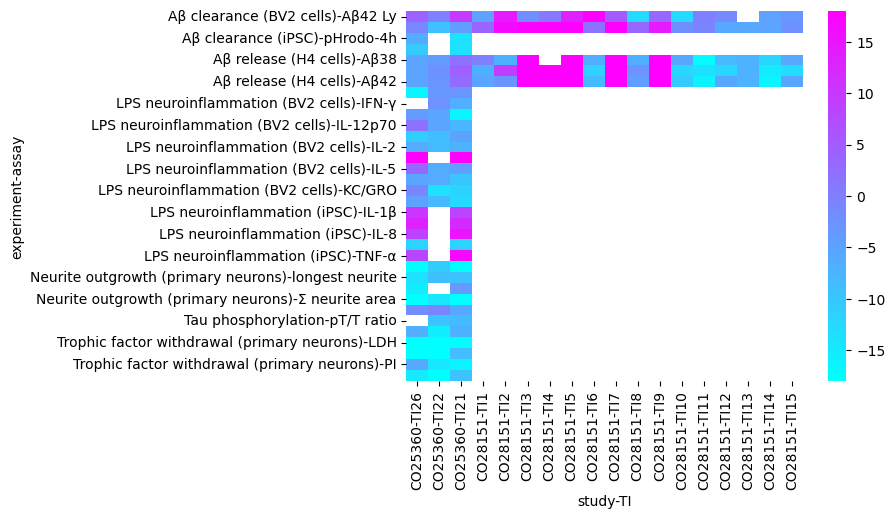

In [5]:
fig, ax = plt.subplots()
sns.heatmap(BF10['2 log BF'].unstack(level=[0, 3]), ax=ax, cmap='cool')

In [6]:
%connect_info

{
  "shell_port": 50099,
  "iopub_port": 50100,
  "stdin_port": 50101,
  "control_port": 50103,
  "hb_port": 50102,
  "ip": "127.0.0.1",
  "key": "9f7deff8-3e0dc193943013b53d632662",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-09-qps-results-summary/024-04-09-qps-results-summary.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-70d1c37c-5728-42fb-b5c4-d754ab21ceb2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
